# Classification: Good vs. Bad Road Conditions

Description: Classifying good and bad road conditions using accelerometer and gyroscope data <b>without</b> pothole labels.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Load and combine all trip data files

In [2]:
numGoodTrips = 10
numBadTrips = 5
dataDir = 'data/Good_Road_Bad_Road/'
goodRoadDF = pd.DataFrame()
badRoadDF = pd.DataFrame()

# Put all good road data into goodRoadDF
for goodRoadIndex in range(1, numGoodTrips+1):
    goodRoadFilePath = dataDir + 'good%s_intervals.csv' % goodRoadIndex
    tripDF = pd.read_csv(goodRoadFilePath)
    goodRoadDF = goodRoadDF.append(tripDF)
    
# Put all bad road data into badRoadDF
for badRoadIndex in range(1, numBadTrips+1):
    badRoadFilePath = dataDir + 'bad%s_intervals.csv' % badRoadIndex
    tripDF = pd.read_csv(badRoadFilePath)
    badRoadDF = badRoadDF.append(tripDF)

# Some data cleaning
goodRoadDF.drop('Unnamed: 0', axis=1, inplace=True)
badRoadDF.drop('Unnamed: 0', axis=1, inplace=True)
goodRoadDF.dropna(inplace=True)
badRoadDF.dropna(inplace=True)
goodRoadDF.reset_index(drop=True, inplace=True)
badRoadDF.reset_index(drop=True, inplace=True)

print (goodRoadDF.shape)
print (badRoadDF.shape)
badRoadDF.head()

(373, 27)
(86, 27)


,meanSpeed,sdSpeed,maxAccelX,maxAccelY,maxAccelZ,maxGyroX,maxGyroY,maxGyroZ,minAccelX,minAccelY,...,meanGyroX,meanGyroY,meanGyroZ,sdAccelX,sdAccelY,sdAccelZ,sdGyroX,sdGyroY,sdGyroZ,condition
0,6.1144,3.403760,0.383011,-0.749512,0.570755,0.103806,0.088366,0.152383,-0.196838,-1.029388,...,-0.015758,-0.055464,0.013032,0.129483,0.056851,0.105767,0.045063,0.082824,0.051742,1.0
1,14.0400,0.572385,0.468079,-0.834000,0.357269,0.148332,0.147995,0.196600,-0.125839,-1.069000,...,-0.044440,-0.026131,0.017567,0.132480,0.069546,0.080862,0.072902,0.102188,0.061287,1.0
2,11.8460,1.657076,0.146255,-0.890030,0.209290,0.049897,0.064855,0.094294,-0.042847,-1.096878,...,-0.033697,-0.017651,0.002942,0.051147,0.055115,0.054110,0.055621,0.056417,0.035661,1.0
3,4.5560,1.746146,0.205185,-0.820557,0.446823,0.116965,0.002499,0.178255,-0.349670,-1.151627,...,-0.000120,-0.260941,0.058930,0.121160,0.066926,0.133372,0.051508,0.130341,0.069800,1.0
4,5.5180,1.172060,0.654892,-0.285400,0.741577,0.532265,0.670697,0.393452,-0.493896,-1.737823,...,0.019539,0.055266,-0.034104,0.305415,0.293934,0.207137,0.281987,0.274525,0.192304,1.0


### Setup Features and Labels

In [3]:
a = goodRoadDF['condition']
b = badRoadDF['condition']
y = np.append(a,b)
frames = [goodRoadDF, badRoadDF]
X = pd.concat(frames)
X = X[['meanSpeed', 'sdSpeed', 'maxAccelX', 'maxAccelY', 'maxAccelZ', 'maxGyroX', 
       'maxGyroY', 'maxGyroZ', 'minAccelX', 'minAccelY', 'minAccelZ', 'minGyroX', 
       'minGyroY', 'minGyroZ', 'meanAccelX', 'meanAccelY', 'meanAccelZ', 
       'meanGyroX', 'meanGyroY', 'meanGyroZ', 'sdAccelX', 'sdAccelY', 'sdAccelZ', 
       'sdGyroX', 'sdGyroY', 'sdGyroZ']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Imbalance of Classes

In [4]:
pd.value_counts(y)

0.0    373
1.0     86
dtype: int64

## Classification: Baseline Model

This is the same as predicting the majority class for every instance. Will serve as a baseline for accuracy/precision/recall.

In [5]:
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print "Accuracy:", accuracy
print "\nClassification Report:"
print(classification_report(y_test, y_pred))
print "\nConfusion matrix:"
confusion_matrix(y_test, y_pred)

Accuracy: 0.822368421053

Classification Report:
             precision    recall  f1-score   support

        0.0       0.82      1.00      0.90       125
        1.0       0.00      0.00      0.00        27

avg / total       0.68      0.82      0.74       152


Confusion matrix:


/Users/Shouvik/Applications/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[125,   0],
       [ 27,   0]])

## Classification: SVM

('Final SVM Test Accuracy: ', 0.92763157894736847)


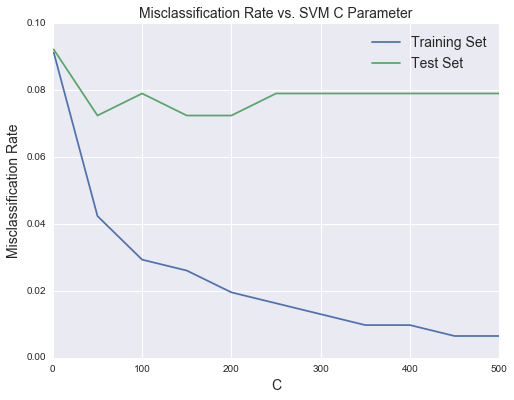

In [8]:
Cs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

for c in Cs:
    clf = svm.SVC(C=c)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(Cs, trainMisclassRate, label="Training Set")
plt.plot(Cs, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. SVM C Parameter', fontsize=14)
plt.xlabel('C', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

# Final SVM Classifier
clf = svm.SVC(C=150)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print ("Final SVM Test Accuracy: ", accuracy)

### Evaluation Metrics: SVM

In [9]:
e = [1,2,3]
b = [1,2,3]
confusion_matrix(y_test, y_pred)

array([[119,   6],
       [  5,  22]])

In [10]:
a = classification_report(y_test, y_pred)
print (a)

             precision    recall  f1-score   support

        0.0       0.96      0.95      0.96       125
        1.0       0.79      0.81      0.80        27

avg / total       0.93      0.93      0.93       152



## Classification: Logistic Regression

('Final Logistic Test Accuracy: ', 0.92763157894736847)


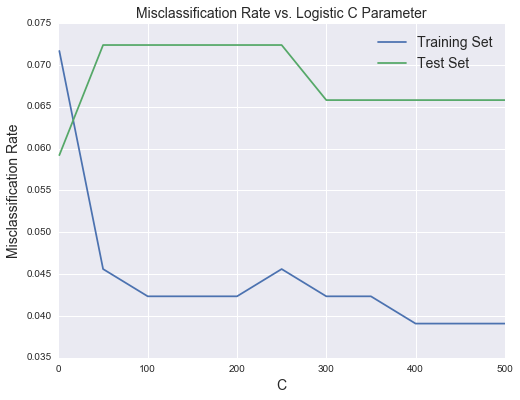

In [11]:
Cs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

for c in Cs:
    clf = LogisticRegression(C=c)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(Cs, trainMisclassRate, label="Training Set")
plt.plot(Cs, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. Logistic C Parameter', fontsize=14)
plt.xlabel('C', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

# Final Logistic Classifier
clf = LogisticRegression(C=250)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print ("Final Logistic Test Accuracy: ", accuracy)

### Evaluation Metrics: LR

In [12]:
e = [1,2,3]
b = [1,2,3]
confusion_matrix(y_test, y_pred)

array([[120,   5],
       [  6,  21]])

In [13]:
a = classification_report(y_test, y_pred)
print (a)

             precision    recall  f1-score   support

        0.0       0.95      0.96      0.96       125
        1.0       0.81      0.78      0.79        27

avg / total       0.93      0.93      0.93       152



## Classification: Random Forest

('Final Random Forest Test Accuracy: ', 0.93421052631578949)


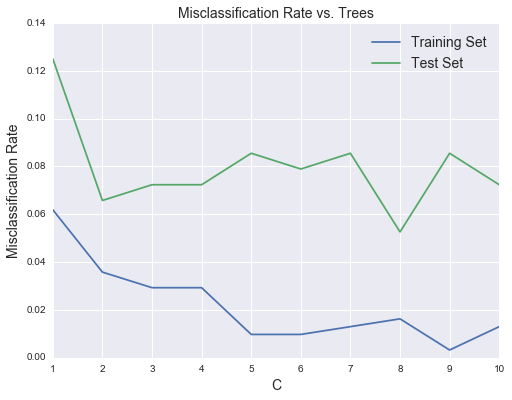

In [14]:
Cs = [1,2,3,4,5,6,7,8,9,10]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

for c in Cs:
    clf = RandomForestClassifier(n_estimators=c)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(Cs, trainMisclassRate, label="Training Set")
plt.plot(Cs, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. Trees', fontsize=14)
plt.xlabel('C', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

# Final Random Forest Classifier
clf = RandomForestClassifier(n_estimators=6)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print ("Final Random Forest Test Accuracy: ", accuracy)

### Evaluation Metrics: Random Forest

In [15]:
e = [1,2,3]
b = [1,2,3]
confusion_matrix(y_test, y_pred)

array([[123,   2],
       [  8,  19]])

In [16]:
a = classification_report(y_test, y_pred)
print (a)

             precision    recall  f1-score   support

        0.0       0.94      0.98      0.96       125
        1.0       0.90      0.70      0.79        27

avg / total       0.93      0.93      0.93       152



## Classification: Gradient Boosting

('Final Gradient Boosting Test Accuracy: ', 0.95394736842105265)


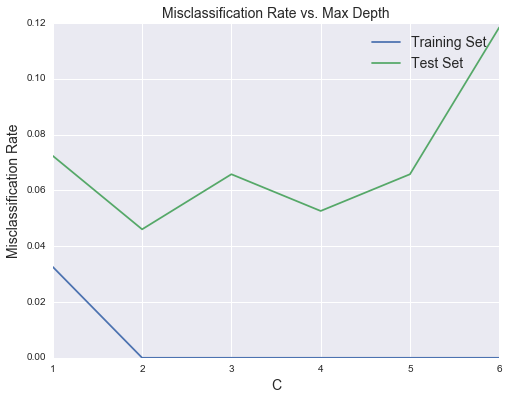

In [18]:
Cs = [1,2,3,4,5,6]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

for c in Cs:
    clf = GradientBoostingClassifier(max_depth=c)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(Cs, trainMisclassRate, label="Training Set")
plt.plot(Cs, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. Max Depth', fontsize=14)
plt.xlabel('C', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

# Final Gradient Boosting Classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
clf = GradientBoostingClassifier(max_depth = 2)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print ("Final Gradient Boosting Test Accuracy: ", accuracy)

In [19]:
e = [1,2,3]
b = [1,2,3]
confusion_matrix(y_test, y_pred)

array([[123,   2],
       [  5,  22]])

In [20]:
a = classification_report(y_test, y_pred)
print (a)

             precision    recall  f1-score   support

        0.0       0.96      0.98      0.97       125
        1.0       0.92      0.81      0.86        27

avg / total       0.95      0.95      0.95       152



## Final Model: Gradient Boosting

Training the gradient boosting model on the entire dataset (not just training data).

In [24]:
clf = GradientBoostingClassifier(max_depth = 2)
clf.fit(X, y)
clf

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

Save classifier to pickled file.

In [25]:
import cPickle as pickle

roadConditionsClassifier = {
    'classifier': clf
}
pickle.dump(roadConditionsClassifier, open('roadConditionsClassifier.p', 'wb'))